<div style="text-align:center"><span style="color:purple; font-family:helvetica; font-size:2.0em;">Locomotion planning based on Divergent Component of Motion(DCM)</span></div>

In this project you will plan CoM trajectory by using DCM concept for locomotion on flat terrain.
In this way We need to have three blocks of DCM Planner, Foot Trajectory Planner and Inverse Kinematics.
The only Block that you need to implement is DCM Planner. In another words you only need to open and edit `DCMTrajectoryGenerator.py` class and following the comments that has been written in this class. The other parts has been already implemented. In the following you can go forward and run the jupyter notebook step by step until you reach to "Implementation of Planning DCM and CoM Trajectories" that you need to implement `DCMTrajectoryGenerator.py` and at the end you sould have the DCM and CoM vector with a size of 4320 that will be used in the inverse kinematics.

<div style="text-align:center"><span style="color:black; font-family:helvetica; font-size:1.7em;">Importing the required libraries</span></div>

In [1]:
#In the following we import the classes that we need for simulation
import time
import pybullet #pybullet simulator
import pybullet_data
import numpy as np # numpy library for matrix computatios
from FootTrajectoryGenerator import * # Foot trajectory generation Class

#uncomment after implementation
from DCMTrajectoryGenerator import * #  DCM trajectory generation Class(will be implemented by students)
from RobotUtils import * # Class related to Inverse Kinematics 

<div style="text-align:center"><span style="color:black; font-family:helvetica; font-size:1.7em;">Preparing Pybullet environment</span></div>

In [2]:
#In the following we create an object of dynamic engine of pybullet and we connect it to the Pybullet GUI
phisycsClient = pybullet.connect(pybullet.GUI)
pybullet.setAdditionalSearchPath(pybullet_data.getDataPath())

In [3]:
#In the following we load the urdf model of the robot and we specify the setting for the simulation
pybullet.resetSimulation()
planeID = pybullet.loadURDF("plane.urdf")
pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_RENDERING,0)
pybullet.setGravity(0,0,-9.81)
atlas=robotID = pybullet.loadURDF("atlas/atlas_v4_with_multisense.urdf", [0,0,0.93],useFixedBase = 0)
pybullet.setPhysicsEngineParameter(numSubSteps=1)
pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_RENDERING,1)
pybullet.setRealTimeSimulation(0)

<div style="text-align:center"><span style="color:black; font-family:helvetica; font-size:1.7em;">Planning Feet Trajectories</span></div>

In [4]:
#In this part we will specify the steps position and duration and we will implement foot trajectory generation
doubleSupportDuration = 0.14 #We select 0.25 second as DS duration
stepDuration = 0.7 #We select 1.2 second as step duration(step duration=SS+DS)
pelvisHeight= 0.72 #Constant pelvis(CoM) height during walking
maximumFootHeight = 0.05 #The maximum height of swing foot during each step

FootPlanner = FootTrajectoryGenerator(stepDuration, doubleSupportDuration, maximumFootHeight) #We create an object of foot FootTrajectoryGenerator Class
stepWidth=0.12 #=lateralDistanceOfFeet/2
stepLength=0.14 #longitudinal distance between two sequential feet stepLength=stepStride/2, 
numberOfFootPrints=17
FootPrints=np.empty((numberOfFootPrints, 3))

#In the following we define the foot step positions
for i in range(0,numberOfFootPrints):
    if(i%2==0):
        if(i==0):
            FootPrints[i][:]=[i*stepLength,stepWidth,0.0]
        elif(i==numberOfFootPrints-1):
            FootPrints[i][:]=[(i-2)*stepLength,stepWidth,0.0]            
        else:
            FootPrints[i][:]=[(i-1)*stepLength,stepWidth,0.0]
    else:
        FootPrints[i][:]=[(i-1)*stepLength,-stepWidth,0.0]
            

FootPlanner.setFootPrints(FootPrints)#We set the foot step positions
FootPlanner.generateTrajectory() #We generate the foot trajectory 
leftFootTrajectory = np.array(FootPlanner.getLeftFootTrajectory())
rightFootTrajectory = np.array(FootPlanner.getRightFootTrajectory())

<div style="text-align:center"><span style="color:black; font-family:helvetica; font-size:1.7em;">Plot Feet Trajectories</span></div>

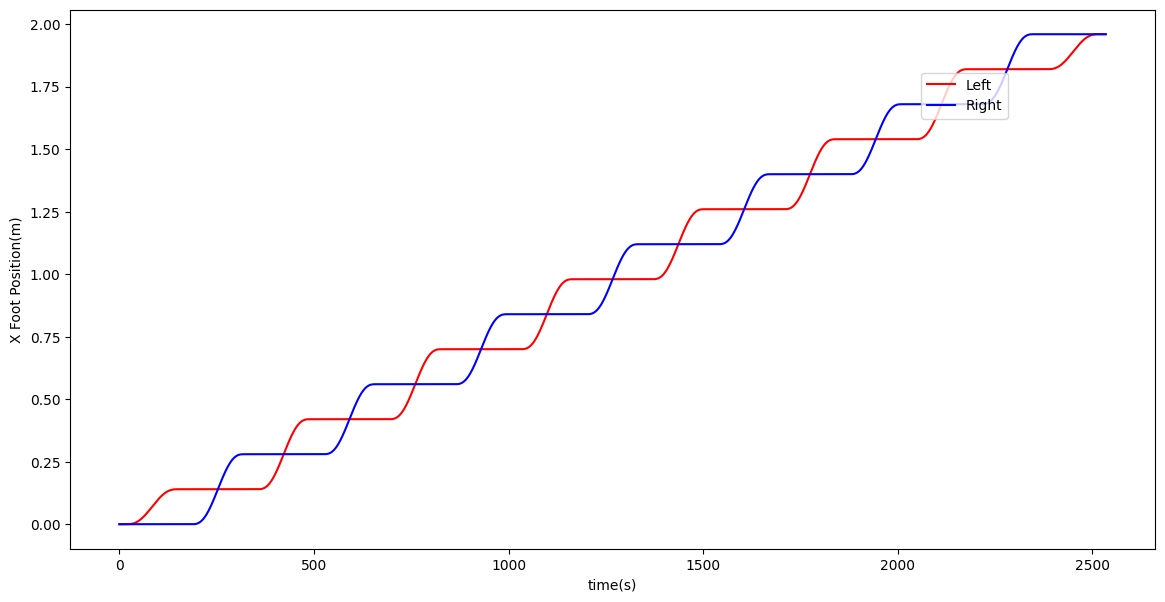

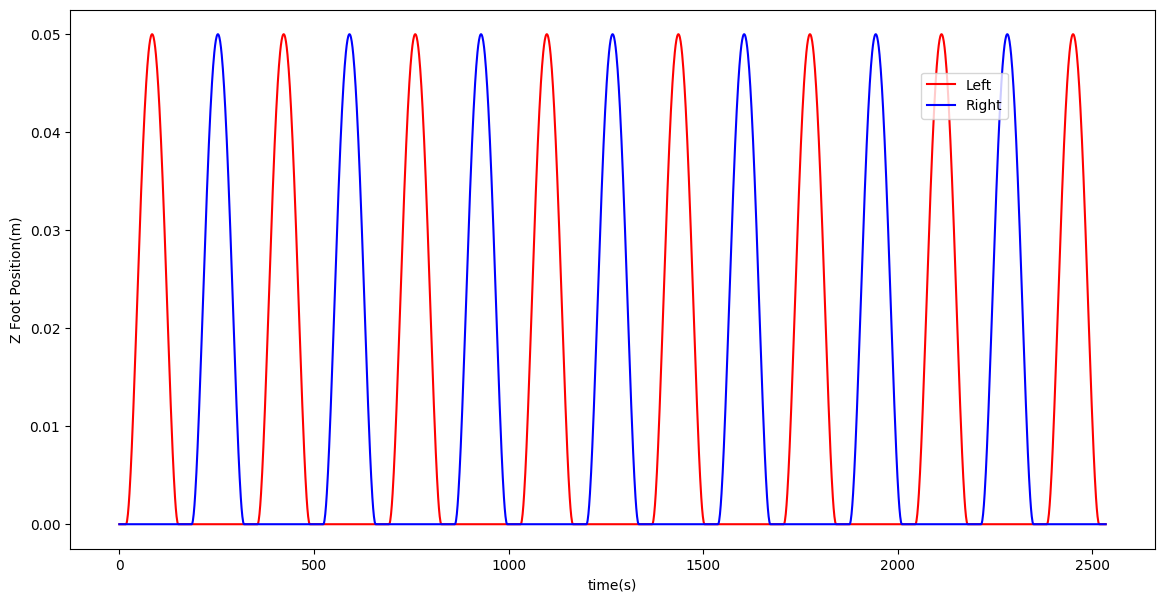

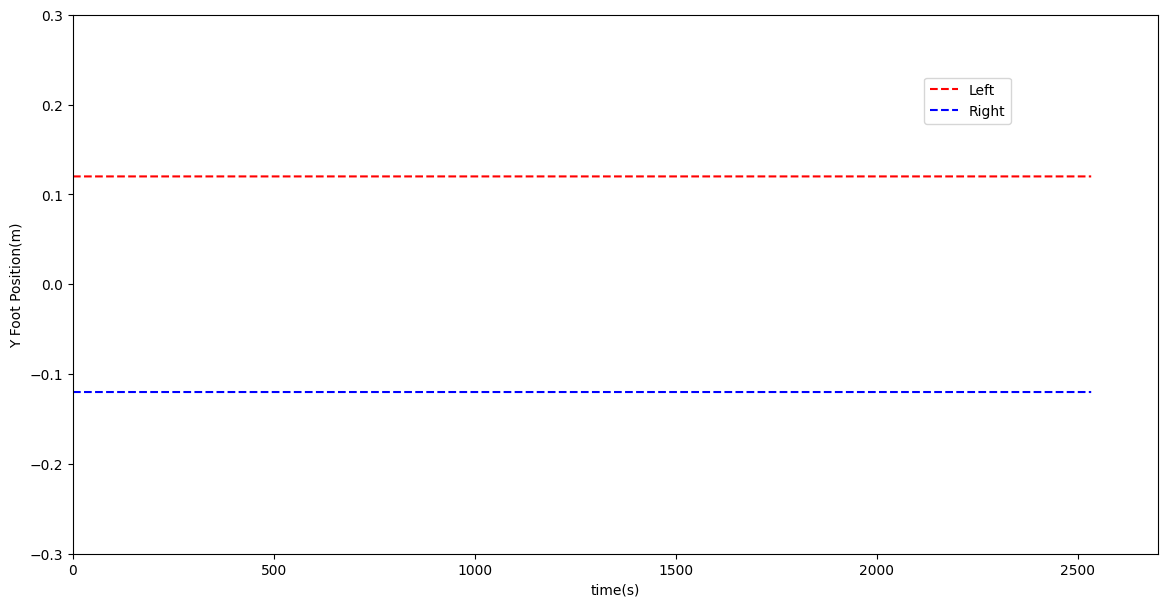

In [5]:
        tempL=np.array(FootPlanner.lFoot_)
        tempR=np.array(FootPlanner.rFoot_)
        figg1, (ax1) = plt.subplots(figsize = (14, 7))
        ax1.plot(tempL[:,0],'r',label="Left")
        ax1.plot(tempR[:,0],'b',label="Right")
        ax1.set_xlabel('time(s)')
        ax1.set_ylabel('X Foot Position(m)')
        figg1.legend(bbox_to_anchor=(0.8, 0.8))
        plt.show()
        
        figg2, (ax3) = plt.subplots(figsize = (14, 7))
        ax3.plot(tempL[:,2],'red',label="Left")
        ax3.plot(tempR[:,2],'blue',label="Right")
        ax3.set_xlabel('time(s)')
        ax3.set_ylabel('Z Foot Position(m)')
        figg2.legend(bbox_to_anchor=(0.8, 0.8))
        plt.show() 
        
        figg3, (ax2) = plt.subplots(figsize = (14, 7))
        ax2.plot(tempL[:,1],'--r',label="Left")
        ax2.plot(tempR[:,1],'--b',label="Right")
        ax2.set_xlabel('time(s)')
        ax2.set_ylabel('Y Foot Position(m)')
        ax2.set(xlim=(-0.2, 2700), ylim=(-0.3, 0.3))
        figg3.legend(bbox_to_anchor=(0.8, 0.8))
        plt.show() 

<div style="text-align:center"><span style="color:black; font-family:helvetica; font-size:1.7em;"Locomotion Planning based on DCM</span></div>

<div style="text-align:center"><span style="color:black; font-family:helvetica; font-size:1.7em;">DCM and CoM Motion Planning</span></div>

In this section we will plan DCM and CoM trajectory by the method that has been presented in the following paper:
"Englsberger, Johannes, Christian Ott, and Alin Albu-Schäffer. "Three-dimensional bipedal walking control based on divergent component of motion." Ieee transactions on robotics 31.2 (2015): 355-368.(254)"


Here we elaborate the equation in details. For the inverted pendulum equation we have:
<img src="img/invertedpendulum.png" width=300 height=300 />

\begin{equation}
\ddot x_c=\omega^2(x_c-r_{CoP})  \; \; \; \; \; \; (1)
\end{equation}

This equation has been drived by finding the momentum around COP(ZMP) that is equal to zero by having dynamic balancing condition. Then we define the DCM dynamics as following:

$$ \xi=x_c + \frac{\dot x_c}{\omega} \; \; \; \; \; \; (2)$$

where $\xi $is the DCM, $x_c$ is the CoM position and velocity and $\omega=\sqrt{\frac{g}{z_c}}$ is the natural frequency of the DCM dynamics. By reordering (2), we can derive the CoM dynamics:

$$\dot x_c=\omega(\xi-x_c) \; \; \; \; \; \; (3)$$
 This shows that the CoM has a stable first-order dynamics. (i.e., it follows the DCM). By differentiating 2) and inserting (3) and (1), we have the DCM dynamics:
$$\dot \xi=\omega(\xi-r_{CoP}) \; \; \; \; \; \; (4) $$


The DCM has an unstable first-order dynamics (it is “pushed” by the CoP), whereas the CoM follows the DCM with the stable first-order dynamics. 

To find the desired DCM trajectory from given constant $CoP$s, the solution of DCM Dynamics is:

$$\xi(t)=r_{cop}+(\xi_{0}-r_{cop})e^{\omega t} \; \; \; \; \; \; (5) $$

Where $\xi_0 =\xi(0)$. The “internal” timestep t is reset at the beginning of each step, i.e., $t \in [0,T] $ ($T$ is the duration of the step). In the following, we will present a step by step method for DCM and CoM motion planning based on the (5). The step 1


1. First, we select the foot step position and step duration based on the desired velocity and considering the kinematic and dynamic constraint of the robot: 

.
<img src="img/00.png" width=300 height=300 />
.

2. Place the desired CoP in a fixed location inside of the foot print(This condition garantee having dynamic balance during locomotion):

.
<img src="img/0.png" width=300 height=300 />
.


3. We place the last DCM position on the last CoP(Capturability constraint). For planning, we assume that the DCM will come to a stop over the final previewed foot position, i.e., $\xi_{eos,N-1}=r_{cop,N}$

.
<img src="img/1.png" width=300 height=300 />
.


4.  By having  the constant desired $CoP$s position for each step and the last DCM Position(located on CoP),  we find the desired DCM locations at the end of each step via recursion using equation (5):

$$\xi_{eos,i}=r_{cop,i}+(\xi_{ini,i}-r_{cop,i})e^{\omega T} \; \; \; \; \; \; (6)$$

$$\xi_{ini,i}=r_{cop,i}+(\xi_{eos,i}-r_{cop,i})e^{-\omega T} \; \; \; \; \; \; (7) $$
$$\xi_{eos,i-1}=\xi_{ini,i}\; \; \; \; \; \; (8)$$

.
<img src="img/2.png" width=400 height=400 />
.

 $\xi_{ini,i}$ is the ith initial desired DCM.
 

 
5. Now, the reference trajectories for the DCM position of $i$th step can be computed as:$$\xi_i(t)=r_{cop,i}+(\xi_{eos,i}-r_{cop,i})e^{\omega (t-T)}\; \; \; \; \; \; (9)$$ The “internal” step time t is reset at the beginning of each step, i.e., $t \in [0,T] $ ($T$ is the duration of the step).

.
<img src="img/3.png" width=400 height=400 />
.



<div style="text-align:center"><span style="color:black; font-family:helvetica; font-size:1.7em;">Implementation of Planning DCM and CoM Trajectories</span></div>

In [6]:
CoPOffset=np.array([0.0,0.0]) #Offset between CoP and footprint position 

DCMPlanner = DCMTrajectoryGenerator(pelvisHeight, stepDuration)#We create an object of foot DCMTrajectoryGenerator Class
CoPPositions=np.empty((DCMPlanner.numberOfSteps+1, 3))#Initialization of the CoP array

#In the following we define the foot step positions
for i in range(0,DCMPlanner.numberOfSteps+1):
    if(i%2!=0):
        CoPPositions[i][:]=[(i)*stepLength-CoPOffset[0],stepWidth-CoPOffset[1],0.0]
        if(i==1):
            CoPPositions[i][:]=[(i)*stepLength,stepWidth-CoPOffset[1],0.0]
    else:
        CoPPositions[i][:]=[(i)*stepLength-CoPOffset[0],-stepWidth+CoPOffset[1],0.0]
        if(i==0):
            CoPPositions[i][:]=[(i)*stepLength,-stepWidth+CoPOffset[1],0.0]
        
DCMPlanner.setCoP(CoPPositions)#We set the desired CoP positions
DCMPlanner.setFootPrints(FootPrints)#We set the foot steps positions
DCMTrajectory = DCMPlanner.getDCMTrajectory()#At the end of DCM Planning the size of DCM vector should be 4320
initialCoM = np.array([0.0,0.0,DCMPlanner.CoMHeight])
comTrajectory = DCMPlanner.getCoMTrajectory(initialCoM)
DCMPlanner.calculateCoPTrajectory()

i =  12 omega =  3.6912057650583505 result =  [1.82 0.12 0.  ] 

i =  11 omega =  3.6912057650583505 result =  [ 1.69056766 -0.10188401  0.        ] 

i =  10 omega =  3.6912057650583505 result =  [1.55136534 0.10325147 0.        ] 

i =  9 omega =  3.6912057650583505 result =  [ 1.41142555 -0.10314825  0.        ] 

i =  8 omega =  3.6912057650583505 result =  [1.2714301  0.10315604 0.        ] 

i =  7 omega =  3.6912057650583505 result =  [ 1.13143044 -0.10315545  0.        ] 

i =  6 omega =  3.6912057650583505 result =  [0.99143047 0.10315549 0.        ] 

i =  5 omega =  3.6912057650583505 result =  [ 0.85143047 -0.10315549  0.        ] 

i =  4 omega =  3.6912057650583505 result =  [0.71143047 0.10315549 0.        ] 

i =  3 omega =  3.6912057650583505 result =  [ 0.57143047 -0.10315549  0.        ] 

i =  2 omega =  3.6912057650583505 result =  [0.43143047 0.10315549 0.        ] 

i =  1 omega =  3.6912057650583505 result =  [ 0.29143047 -0.10315549  0.        ] 

i =  0 omega 

C:\Users\yacin\Documents\EPFL\MA3\Legged Robots\Practicals\Project 1\LR-Biped-First-Project-main\DCMTrajectoryGenerator.py:62: ComplexWarning: Casting complex values to real discards the imaginary part
  self.DCMForEndOfStep[i] = (self.CoP[i+1] + (self.DCMForEndOfStep[i+1] - self.CoP[i+1])*exp(-self.omega*self.stepDuration))


<div style="text-align:center"><span style="color:black; font-family:helvetica; font-size:1.7em;">Plot DCM and CoM Trajectories</span></div>

C:\Users\yacin\anaconda3\envs\LeggedRobots\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


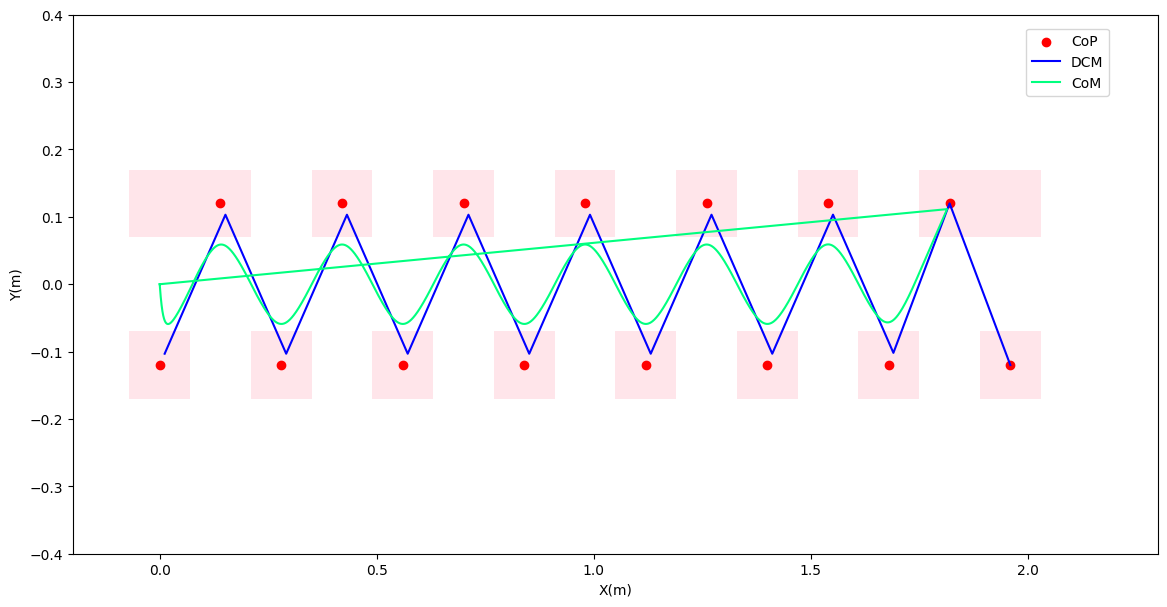

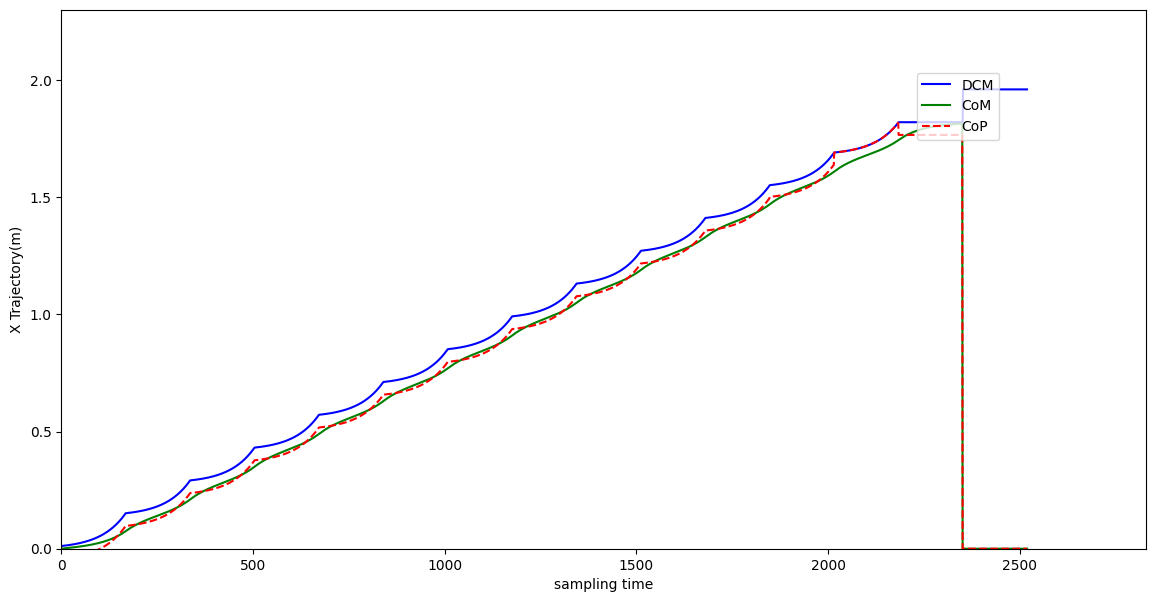

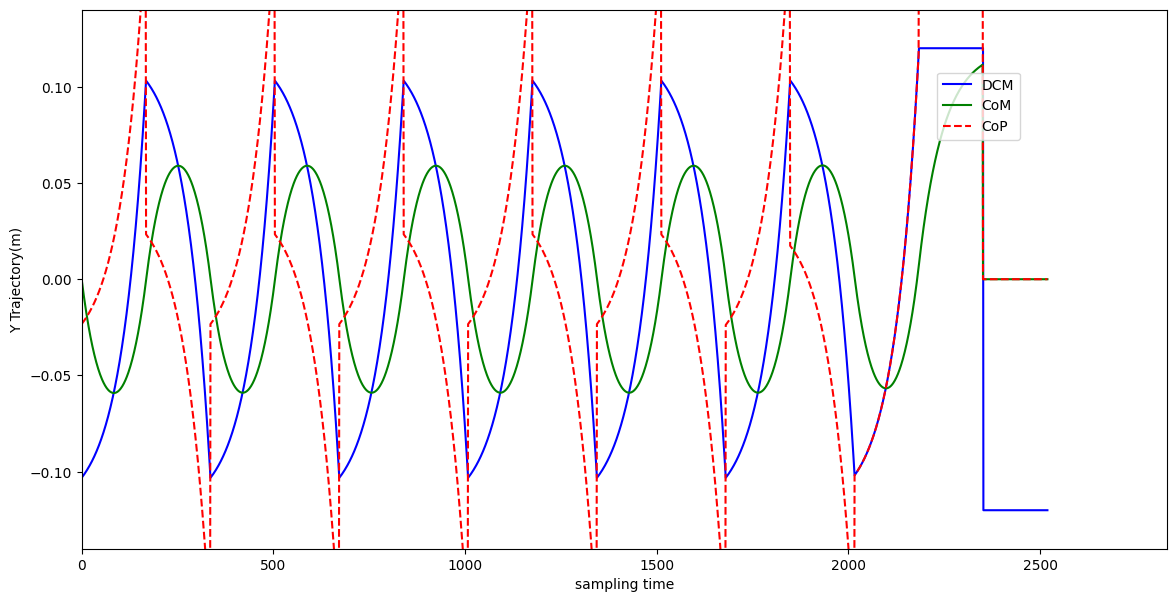

In [7]:
fig4, (ax4) = plt.subplots(figsize = (14, 7))
footWidth=0.1
footLength=0.14
for i in range(0,np.size(DCMPlanner.footPrints,0)):
    rect = plt.Rectangle((DCMPlanner.footPrints[i,0]-footLength/2, DCMPlanner.footPrints[i,1]-footWidth/2),footLength, footWidth,
           facecolor="pink", alpha=0.4) 
    ax4.add_patch(rect)
ax4.set(xlim=(-0.2, 2.3), ylim=(-0.4, 0.4))
ax4.scatter(DCMPlanner.CoP[:,0],DCMPlanner.CoP[:,1],c='red',label="CoP")
ax4.set_xlabel('X(m)')
ax4.set_ylabel('Y(m)')
ax4.plot(np.array(DCMPlanner.DCM)[:,0],np.array(DCMPlanner.DCM)[:,1],'blue',label="DCM")
ax4.plot(DCMPlanner.CoM[:,0],DCMPlanner.CoM[:,1],'springgreen',label="CoM")
fig4.legend(bbox_to_anchor=(0.87, 0.87))
plt.show()


figg5, (ax5) = plt.subplots(figsize = (14, 7))
ax5.plot(np.array(DCMPlanner.DCM)[:,0],'b',label="DCM")
ax5.plot(DCMPlanner.CoM[:,0],'g',label="CoM")
ax5.plot(DCMPlanner.CoPTrajectory[:,0],'--r',label="CoP")
ax5.set_xlabel('sampling time')
ax5.set_ylabel('X Trajectory(m)')
ax5.set(xlim=(-0.0,2830), ylim=(-0.0, 2.3))
figg5.legend(bbox_to_anchor=(0.8, 0.8))
plt.show() 

figg6, (ax6) = plt.subplots(figsize = (14, 7))
ax6.plot(np.array(DCMPlanner.DCM)[:,1],'b',label="DCM")
ax6.plot(DCMPlanner.CoM[:,1],'g',label="CoM")
ax6.plot(DCMPlanner.CoPTrajectory[:,1],'--r',label="CoP")
ax6.set_ylabel('Y Trajectory(m)')
ax6.set_xlabel('sampling time')
ax6.set(xlim=(0,2830), ylim=(-0.14, 0.14))
figg6.legend(bbox_to_anchor=(0.8, 0.8))
plt.show() 
 

<div style="text-align:center"><span style="color:black; font-family:helvetica; font-size:1.7em;">Implementing Trajectories on the Robot</span></div>


In [8]:
AtlasUtils = RobotUtils()#This object is responsible for inverse kinematics

#Preparing the constant joints position for the upper-body joints
leftArmPositions=[-0.2,-1.7,0.3,-0.3,0.0,0.0,0.0]
rightArmPositions=[ 0.2, 1.7,0.3, 0.3,0.0,0.0,0.0]
bodyPositions = [0.0,0.0,0.0,0.0]
leftArmIndex = [3,4,5,6,7,8,9]
rightArmIndex= [11,12,13,14,15,16,17]
bodyIndex = [0,1,2,10]
leftLegIndex=[18,19,20,21,22,23]
rightLegIndex=[24,25,26,27,28,29]
jointsIndex= np.zeros(30)
jointsPositions= np.zeros(30)
jointsIndex[0:4]=bodyIndex
jointsIndex[4:11]=rightArmIndex
jointsIndex[11:18]=leftArmIndex
jointsIndex[18:24]=rightLegIndex
jointsIndex[24:30]=leftLegIndex
jointsPositions[0:4]=bodyPositions
jointsPositions[4:11]=rightArmPositions
jointsPositions[11:18]=leftArmPositions


for i in range(1000):  #1000 sampling time will be allocated for the initialization of the robot position
    lowerBodyJoints= AtlasUtils.doInverseKinematics([0.0,0.0,0.9 - (i/1000)* (0.9-DCMPlanner.CoMHeight)], np.eye(3),[0.0,0.13,0.0], np.eye(3),[0.0, -0.13,0.0], np.eye(3))
    jointsPositions[24:30] = lowerBodyJoints[6:12]
    jointsPositions[18:24] = lowerBodyJoints[0:6]
    pybullet.setJointMotorControlArray(bodyIndex=robotID,
                                jointIndices=jointsIndex,
                                controlMode=pybullet.POSITION_CONTROL,
                                targetPositions = jointsPositions)
    pybullet.stepSimulation()
    time.sleep(0.0002)
    
time.sleep(1)#Just wait for a second

#Solving the inverse kinematic and sending the joints position command to the robot
for i in range(int((DCMPlanner.numberOfSamplesPerSecond) * CoPPositions.shape[0] * DCMPlanner.stepDuration)):
    lowerBodyJoints = AtlasUtils.doInverseKinematics(comTrajectory[i], np.eye(3),leftFootTrajectory[i], np.eye(3),rightFootTrajectory[i], np.eye(3))
    jointsPositions[24:30] = lowerBodyJoints[6:12]
    jointsPositions[18:24] = lowerBodyJoints[0:6]
    pybullet.setJointMotorControlArray(bodyIndex=robotID,
                                jointIndices=jointsIndex,
                                controlMode=pybullet.POSITION_CONTROL,
                                targetPositions = jointsPositions)
    
    
    
    #The following part, at every 14 sampling period, will plot the foot and pelvis trajectory in pybullet 
    if(i>14 and i%14==0):
        pybullet.addUserDebugLine(comTrajectory[i-14],comTrajectory[i],[0,0.9,0.0],4,140)
        pybullet.addUserDebugLine(leftFootTrajectory[i-14],leftFootTrajectory[i],[1.0,0.0,0.8],4,140)
        pybullet.addUserDebugLine(rightFootTrajectory[i-14],rightFootTrajectory[i],[0.1,0.9,0.8],4,140)
    pybullet.stepSimulation()



C:\Users\yacin\AppData\Local\Temp\ipykernel_10748\3922703801.py:28: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  pybullet.setJointMotorControlArray(bodyIndex=robotID,


TypeError: ufunc 'arctan2' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
time.sleep(7)
pybullet.disconnect()

Questions:

1-Based on equation (5), which physical parameters will affect the rate of divergence of the DCM dynamics?

2-In the DCM motion planning, how do we guarantee dynamic balancing conditions?

3-If we do have dynamic balancing guarantees, why is the robot not able to walk without parameter tuning?

4-In order to achieve stable locomotion, which parameters did you tune and what are their values?

5-Please calculate and plot the real ZMP(CoP) using contact force from pybullet during locomotion.

6-Please tune the step position and duration in the "Planning Feet Trajectories" section or any other parameters to achieve faster locomotion. What is the fastest walking speed you can achieve and what are the corresponding parameters?

7-Let's assume we would like to have robot walking on the surface of the moon, by considering the gravity condition of the moon, what's the fastest walking speed that you can achieve and what are the corresponding parameters? 

8-Do we considered double support during DCM planning? What could be the effect of considering double support
for DCM planning?